# Sistema Avaliação de Lances - Kobe
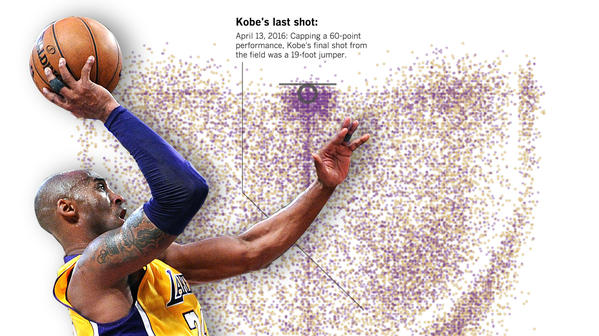

- Implementar um pipeline de processamento de dados com o mlflow, rodada (run) com o nome "PreparacaoDados":
- Implementar o pipeline de treinamento do modelo com o Mlflow usando o nome "Treinamento"
- Registrar o modelo de classificação e o disponibilize através do MLFlow através de API. Selecione agora os dados da base de dados original onde shot_type for igual à 3PT Field Goal (será uma nova base de dados) e através da biblioteca requests, aplique o modelo treinado. Publique uma tabela com os resultados obtidos e indique o novo log loss e f1_score.
- Implemente em um arquivo .py anexo, um dashboard de monitoramento da operação usando Streamlit.

Todos os arquivos desse projeto estão disponíveis no github para clone a partir de: https://github.com/LEBAIMS/modelo_kobe.git

# Diagrama 
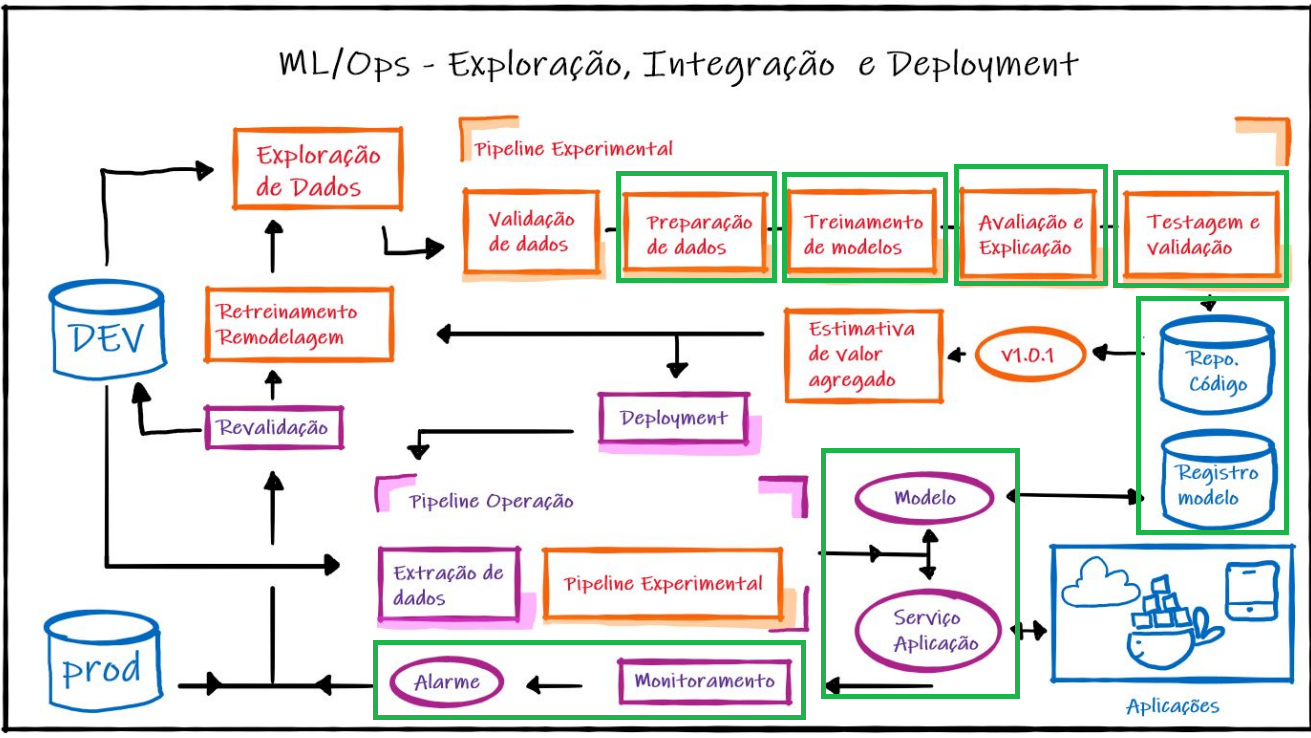

Em nosso projeto, faremos uso das etapas circundadas com a cor verde

- Aquisição de dados: Não faremos uso da etapa pois os dados já foram coletados e estão disponíveis para uso imediato.
- Criação dos modelos: Após as etapas de Preparação de Dados, Treinamento de Modelos, Avaliação e Testagem, podemos registrar um Modelo para modos Staging ou Produção.
- Operação do modelo: Operar o modelo significam fazer uso das etapas Deploymenty e Monitoramento

# PipeLine

A importância de definir e implementar pipelines ajudam diretamente a organizar e segmentar as diversas tarefas necessárias no desenvovimento e na produção de um projeto de aprendizado de máquinas

Uma vez que as etapas estejam separadas e segmentadas em pipelines, torna-se mais fácil manter um projeto e essa prática também permite que diferentes equipes possam cuidar de forma independente de cada pipeline.

# Ferramentas

Ferramentas como Scikit-Learn,  PyCaret, MLFlow e Streamlit auxiliam enormemente na construção dos pipelines, pois englobam diversas funções que auxiliam a vida do desenvolvedor, que em especial podemos enumerar:

- Funções de treinamento: Podemos fazer uso do Scikit-Learn para as tarefas de treinamento e do Pycaret para automatizar as diversas funções oferecidas por essa primeira ferramenta, permitindo comparar modelos, criar artefatos e analisar resultados com extrema facilidade

- Rastreamento de experimentos: Aqui podemos fazer tanto do Pycaret, para gerar os dados, quanto o MlFlow, que além de armazenar e disponibilizar modelos treinados, permite registrar diversas métricas, parâmetros e artefatos gerados pelos modelos, permitindo assim analisar em diversos momentos distintos, o estado do experimento.

- Provisionamento (Deployment): Faz grande uso do Pycaret, através de suas funções específicas para essa finalidade, tais como predict_model(), finalize_model(), deploy_model(), save_model(), load_model(), save_config(), load_config(). Lembrando que modelos podem ser salvos pelo MlFlow

- Monitoramento da saúde do modelo: Fazendo uso dos modelos disponibilizados no MlFlow, podemos criar códigos específicos de monitoramento com funções do Scikit-Learn para monitorar de tempos em tempos a saúde do modelo, analizando a predição com novas amostras de dados, a fim de verificar se o resultado objetivo do modelo ainda está aderente a sua proposta. Também podemos fazer uso do Streamlit para fornecer novas amostras e analisar resultados através de uma interface web, de fácil desenvolvimento.

- Atualização de modelo: Uma vez identificado uma degradação do modelo, devemos atualizá-lo através de novo treinamento, para isso entram as bibliotecas Scikit-Learn, Pycaret e atualizar o novo modelo no MlFlow

# Instalação e Importação das Bibliotecas envolvida

In [1]:
#!pip install mlflow
#!pip install pyarrow --user
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install pycaret --user
#!pip install sklearn --user 

In [2]:
import os
import pandas as pd
import seaborn as sn
import pycaret.classification as pc

from sklearn import metrics, model_selection
#from sklearn import model_selection
from sklearn.metrics import log_loss

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import matplotlib.pyplot as plt
import matplotlib as mpl
if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

import numpy as np
SEED = 10
np.random.seed(SEED)

# Reset do estilo de cores do matplotlib 

In [3]:
mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

# Preparação do ambiente MLFlow

In [4]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


In [5]:
# Para monitorar o MLFlow execute a linha abaixo a partir do Anaconda Prompt (ambiente local)
#mlflow ui --backend-store-uri sqlite:///mlruns.db

# Leitura e Preparação dos Dados

- Implementar um pipeline de processamento de dados com o mlflow, rodada (run) com o nome "PreparacaoDados": OK
- Os dados devem estar localizados em "/Data/kobe_dataset.csv": OK
- Observe que há dados faltantes na base de dados! As linhas que possuem dados faltantes devem ser desconsideradas. Você também irá filtrar os dados onde o valor de shot_type for igual à 2PT Field Goal. Ainda, para esse exercício serão apenas consideradas as colunas: lat, lon, minutes remaining, period, playoffs, shot_distance: OK
- A variável shot_made_flag será seu alvo, onde 0 indica que Kobe errou e 1 que a cesta foi realizada. O dataset resultante será armazenado na pasta "/Data/processed/data_filtered.parquet". Ainda sobre essa seleção, informar a dimensão resultante do dataset: OK
- Separe os dados em treino (80%) e teste (20 %) usando uma escolha aleatória e estratificada. Armazene os datasets resultantes em "/Data/operalization/base_{train|test}.parquet: OK
- Registre os parâmetros (% teste) e métricas (tamanho de cada base) no MlFlow: OK

Sobre bases de treiamento e testes: É importante que as bases tanto de treinamento quanto de teste estejam o mais similares possíveis, quanto a distribuição das classes. Desta forma, ao invés de simplesmente dividir, pegando, por exemplos os primeiros 80% registros para treino e os 20% restantes para testes, podendo gerar um "overfitting" alto, fazemos usos de técnicas, como validação cruzada (StratifiedKfold), que dividirá a base em partes iguais (folds), extraindo de cada fold desse a parcela referente ao base de testes. Isso porém ocorrerá várias vezes, analisando o desempenho do treino em cada uma dessas etapas. Nesse projeto faremos uso da metodologia StratifiedKfold que é uma versão melhorada do KFold, que garante uma melhor distribuição em bases desbalanceadas. 


In [23]:
mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados')

fname = '../Data/kobe_dataset.csv'
data = pd.read_csv(fname,sep=',')
#data.head()

top_features = ['lat','lon','minutes_remaining','period','playoffs','shot_distance']
target_col = 'shot_made_flag'

# Base de kobes para uso futuro como monitoramento
data_novelty = data[data['shot_type'] != '2PT Field Goal']
data_novelty = data_novelty[top_features + [target_col] + ['shot_type']]
data_novelty = data_novelty.dropna()

# Filtra somente linhas com shot_type = '2PT Field Goal'
data = data[data.shot_type == '2PT Field Goal']

# Dropa somente onde houver NA nas colunas uteis, para isso salva-se nova versão do dataframe
data = data[top_features + [target_col]]
print(f'Linhas antes do drop {data.shape}')
data = data.dropna()
print(f'Linhas depois do drop {data.shape}')

# Salvando dados
data.to_parquet('../Data/processed/data_filtered.parquet')    
data_novelty.to_parquet('../Data/processed/data_novelty.parquet')   

# Separar Treino e Teste 
test_size = 0.2
(xtrain, xtest, 
ytrain, ytest) = model_selection.train_test_split(data[top_features], 
                                                  data[target_col],
                                                  test_size=test_size,
                                                  stratify=data[target_col])
xtrain[target_col] = ytrain
xtest[target_col] = ytest

# Salvando dados de Treino e Teste
xtrain.to_parquet('../Data/processed/data_train.parquet')    
xtest.to_parquet('../Data/processed/data_test.parquet')   
    
# LOG DE PARAMETROS DO MODELO
mlflow.log_param('test size', test_size)
mlflow.log_param("top features", top_features)
mlflow.log_param("target col", target_col)

# LOG DE METRICAS GLOBAIS
mlflow.log_metric('test shape', ytest.shape[0])
mlflow.log_metric("train shape", xtrain.shape[0])
mlflow.log_metric("novelty shape", data_novelty.shape[0])  
    
mlflow.end_run()       

Linhas antes do drop (24271, 7)
Linhas depois do drop (20285, 7)


# Treinamento e Comparação dos Modelos

- Implementar o pipeline de treinamento do modelo com o Mlflow usando o nome "Treinamento": Ok
- Com os dados separados para treinamento, treine um modelo com regressão logística e outro para classificação do sklearn usando a biblioteca pyCaret: Ok
- Registre a função custo "log loss" usando a base de teste: Ok para ambos os modelos: Ok
- Registre a função custo "log loss" e F1_score para esse novo modelo de classificação: Ok

Por que a escolha de árvore de decisão: Na realidade a escolha já foi posta, mas poderia destacar que a árvora de decisão tem como vantagem um custo de processamento menor para prever dados, pois ele diminui com cada ponto de dados adicional, também, porque funciona para dados categóricos (não é o caso) ou numéricos e proque modela problemas com várias saídas.

In [8]:
# Treinando e comparação dos modelos - a gravação no MlFlow será feita diretamente pelo Pycaret, sem pipeline

s = pc.setup(data = data, 
                 target = target_col,
                 train_size=0.8,
                 silent = True,
                 fold_strategy = 'stratifiedkfold',
                 fold = 10,
                 log_experiment = True, 
                 experiment_name = experiment_name, 
                 log_plots = True,
                 verbose=False
                )

models_names = ['lr', 'dt']
pc.add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)
models = pc.compare_models(include = models_names, n_select=2)
mlflow.end_run()   

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,TT (Sec)
lr,Logistic Regression,0.5765,0.5956,0.4868,0.5659,0.5233,0.1462,0.1475,14.6282,5.1490
dt,Decision Tree Classifier,0.5320,0.5148,0.5746,0.5090,0.5397,0.0673,0.0679,16.1628,0.1470


In [12]:
#Comparando Modelo

mlflow.start_run(experiment_id=experiment_id, run_name = 'TreinamentoModelo', nested = True)

best_model = None
logloss_ant = 0
best_model_name = ''

# Salvando métrica e artefatos dos modelos
for x in [0, 1]:
    model = models[x]
    pred = pc.predict_model(model, xtest)
    pred['Label'] = pred['Label'].astype(float)
    logloss = log_loss(ytest, pred['Label'])
    model_name = models_names[x]
    if logloss > logloss_ant:
        best_model = model
        loglossant = logloss
        best_model_name = model_name
    mlflow.log_metric(f'Modelo {model_name} - Log Loss', logloss)
    # Gravar F1 Score somente para o modelo de árvore de decisão
    if model_name == 'dt':
        mlflow.log_metric(f'Modelo {model_name} - F1 score', metrics.f1_score(ytest, pred['Label']))

mlflow.log_param("best model", best_model_name)   
    
# Grava Artefato no Log do run, e nao do modelo respectivo
classification_plots = [ 'auc','pr','confusion_matrix',
#                          'error', 'class_report', 
                        'threshold', 'learning','vc','feature']
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(best_model, plot=plot_type, save=True, use_train_data=False)
        mlflow.log_artifact(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue
        
mlflow.end_run()        

# Salvando e Registrando Modelo

- Registre o modelo de classificação e o disponibilize através do MLFlow através de API: OK
- Selecione agora os dados da base de dados original onde shot_type for igual à 3PT Field Goal (será uma nova base de dados) e através da biblioteca requests, aplique o modelo treinado: OK
- Publique uma tabela com os resultados obtidos: OK
- Indique o novo log loss e f1_score: OK

Observações:
- Após aplicar o novo banco de dados, baseado no shot_type = 3PT Field Goal, verificou-se que o modelo caiu, mas pela variação do log loss, ainda seria aderente. Essa primeira métrica caiu de 16.1628 para 15.54, que não foi muito, porém o F1 Score caiu de 0.5397 para 0.3751, se analisado por essa métrica, deixaria de ser aderente.
- Descreva como podemos monitorar a saúde do modelo no cenário com e sem a disponibilidade da variável resposta para o modelo em operação
- Descreva as estratégias reativa e preditiva de retreinamento para o modelo em operação.

In [13]:
registered_model_name = 'modelo_kobe'
model_version = -1 # recuperar a ultima versao
nexamples = 4
            
# Pycaret exporta o pipeline de transformação e o modelo
pc.save_model(best_model, f'./{registered_model_name}') 

# Carrega novamente o pipeline + bestmodel
model_pipe = pc.load_model(f'./{registered_model_name}')

# Assinatura do Modelo Inferida pelo MLFlow
model_features = list(data.drop(target_col, axis=1).columns)
inf_signature = infer_signature(data[model_features], model_pipe.predict(data))

# Exemplo de entrada para o MLmodel
input_example = {x: data[x].values[:nexamples] for x in model_features}
    
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
       sk_model=model_pipe,
       artifact_path="sklearn-model",
       registered_model_name=registered_model_name,
       signature = inf_signature,
       input_example = input_example)

# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
   model_version = client.get_latest_versions(registered_model_name)[-1].version

# Registrar o modelo como staging
client.transition_model_version_stage(name=registered_model_name,
        version=model_version, # Verificar com usuario qual versao
        stage="Staging")

# LOG DE METRICAS GLOBAIS
mlflow.log_metric("new_version", model_version)

#mlflow.end_run()

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/13 17:04:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 7
Created version '7' of model 'modelo_kobe'.


# Serviço do Modelo 

In [14]:
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
!mlflow models serve -m "models:/modelo_kobe/Staging" --no-conda -p 5001

^C


# Operação Sistema de Classificação de Jogadas

Uma vez que o modelo esteja registrado no MlFlow, o mesmo poderá ser "servido" atráves de API REST, disponível no próprio MlFlow e atráves dessa API, enviar dados pelo método POST para amostra e realizar uma predicção baseada no modelo, conforme demonstrado no código abaixo, usando a base dados "data_novelty" como amostra.

In [52]:
metrics.log_loss

<module 'sklearn.metrics' from 'C:\\Users\\Edgar\\AppData\\Roaming\\Python\\Python38\\site-packages\\sklearn\\metrics\\__init__.py'>

In [57]:
import requests
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

http_data = data_novelty.drop(target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

data_novelty.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

data_novelty.to_parquet('modelo_kobe_operacao.parquet')
result_table = data_novelty[data_novelty.operation_label == 1].sort_values('shot_made_flag', ascending=False)

#Publicando Resultado
result_table.to_parquet('resultado_novelty.parquet')

# Publicando Novo Log loss e novo F1 Score
ll = metrics.log_loss(data_novelty[target_col], data_novelty['operation_label'])
f1 = metrics.f1_score(data_novelty[target_col], data_novelty['operation_label'])
mlflow.log_metric("Novelty Log Loss", ll)
mlflow.log_metric("Novelty F1 Score", f1)

print(f'Novelt Log Loss: {ll}')
print(f'Novelt F1 Score: {f1}')

result_table.head(5)

Novelt Log Loss: 15.54010110207888
Novelt F1 Score: 0.37516037977931743


,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag,shot_type,operation_label
19468,33.8603,-118.0888,1,1,0,25,1.0,3PT Field Goal,1
16173,34.0653,-118.4938,0,4,0,22,1.0,3PT Field Goal,1
21194,33.8173,-118.3788,1,4,0,25,1.0,3PT Field Goal,1
9359,33.8633,-118.0878,8,3,0,25,1.0,3PT Field Goal,1
16250,33.8023,-118.3298,5,3,0,24,1.0,3PT Field Goal,1


# Monitoramento de Modelos

Os modelos, por mais "tunning" que possam ser realizados na sua construção, tendem, com o passar do tempo, sofrerem um degração, pois os dados analisados tendem a sofrer mudanças por vários motivos, como mudanças de paradigmas, eventos temporais, mudança de conveitos ou de costumes, tecnológicos e vários outros.

Por esses motivos, é necessário manter um monitoramento periódico para avaliar a permanência da eficiência do modelo. A periodicidade dessa reavaliação depende de cada caso, podendo até ser em real-time e a sua execução pode ser realizada também de diversas formas, sendo a automatizada a mais indicada, gerando alertas quando essa degradação for identificada, podendo inclusive dar o início a um processo de retreinamento também de forma automática.

A degração de um modelo por ser classificada em tipo, que seriam instantâneo (alguma mudança drástica e inesperada, ou mesmo algum bug), gradual, que pode ser identificada na evolução da degradação em cada monitoramento, recorrente, que conta com eventos temporais recorrentes, como carnaval, natal e etc. e temporário, que são de curto espaço de tempo, imprevisíveis e de curta duração.

O monitoramento de um modelo pode contar com a variável alvo em sua nova amostra, o que torna o processo mais fácil, pois bastaria avaliar uma ou mais métricas e caso essas sejam degradadas em mais de uma tolerência pré-determinada, o alarme é disparado. Porém, quando a variável alvo não está disponível é necessário fazer uso de outras técnicas, como monitorar a distribuição das variáveis de entradas e saídas, em quesitos como média, desvios padrões e divergências. 

# Retreinamento

Como comentado acima, o disparo de um alerta pode dar início a um processo de retreinamento, porém, esse também pode ocorrer mesmo que alertas não sejam disparados, dependendo da estratágia de retreinamento do modelo, que podem ser:

* Preventivo: Essa é a estratégia que não depende de disparos de alertas, pois ela pode ser programada para ocorrer sempre dentro de uma determinada frequencia ou então, quando um quantidade pré-definida de novas informações estiverem dispníveis
* Reativo: Essa estratégia depende do resultado de um monitoramento, seja esse resolvido identificado por um alerta ou não. Uma vez que o monitoramento identifique uma degradação acima de determinada tolerância, o retreiamento é iniciado
* Preditivo: Mesmo antes do resultado de um monitoramento, apenas pelo fato de se identificar algum fato novo que vá impactar no resultado de um modelo, como por exemplo a existência de uma pandemia, é possível já se antecipar e retreinar um modelo sem ter que aguardar o resultado de um monitoramento reativo ou a ocorrência de um monitoramento programado no preventivo.

In [62]:
#mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 150

data_operation = pd.read_parquet('modelo_kobe_operacao.parquet')
data_control = data_operation.sample(min_samples_control, random_state=SEED)
data_control.to_parquet('modelo_kobe_controle.parquet')

print('== DADOS DE CONTROLE ==')
print(metrics.classification_report(data_control[target_col], data_control['operation_label']))
    
# LOG DE PARAMETROS DO MODELO
mlflow.log_param("min_samples_control", min_samples_control)

# LOG DE METRICAS GLOBAIS
cm = metrics.confusion_matrix(data_control[target_col], data_control['operation_label'])
specificity = cm[0,0] / cm.sum(axis=1)[0]
sensibility = cm[1,1] / cm.sum(axis=1)[1]
precision   = cm[1,1] / cm.sum(axis=0)[1]
mlflow.log_metric("Especificidade", specificity)
mlflow.log_metric("Sensibilidade", sensibility)
mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

         0.0       0.58      0.57      0.57        92
         1.0       0.34      0.36      0.35        58

    accuracy                           0.49       150
   macro avg       0.46      0.46      0.46       150
weighted avg       0.49      0.49      0.49       150



# streamlit_modelo.py

O código do arquivo streamlit_modelo.py, que gera o arquivo /Data/kobe_modelo.pkl a ser utilizado pelo arquivo streamlit_dashboard.py

O motivo desse código estar nesse notebook, serve apenas para concentar em um único arquivpo .PDF e facilitar a entrega do trabalho, porém a geração do modelo a ser utilizada pelo arquivo streamlit_dashboard.py poderá ser realizada ao executar a célula abaixo.

Já o arquivo streamlit_dashboard.py, que também seguirá para fins didático em outra célula abaixo, não poderá ser executada a partir desse notebook, pois deverá ser chamado por linha de comando através do comando "streamlit run streamlit_dashboard.py"

In [2]:
import streamlit as st
import pandas
import numpy as np
from sklearn import model_selection, tree, ensemble, metrics, feature_selection
import joblib

fname = '../Data/kobe_dataset.csv'
savefile = '../Data/kobe_modelo.pkl'

############################################ LEITURA DOS DADOS
print('=> Leitura dos dados')
df_kobe = pandas.read_csv(fname,sep=',')
drop_cols = ['game_event_id', 'game_id', 'loc_x', 'loc_y', 'action_type', 'combined_shot_type', 
             'shot_zone_area', 'season', 'shot_zone_basic', 'seconds_remaining', 'team_id',
             'shot_zone_range', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id']
df_kobe.drop(drop_cols, axis=1, inplace=True)
df_kobe = df_kobe.dropna()
kobe_target_col = 'shot_made_flag'
print(df_kobe.head())

############################################ TREINO/TESTE E VALIDACAO
results = {}
for kobe_type in df_kobe['shot_type'].unique():
    print('=> Training for kobe:', kobe_type)
    print('\tSeparacao treino/teste')
    kobe = df_kobe.loc[df_kobe['shot_type'] == kobe_type].copy()
    X = kobe.drop([kobe_target_col, 'shot_type'], axis=1)
    Y = kobe[kobe_target_col]
    ml_feature = list(X.columns)
    # train/test
    xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)
    cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)
    print('\t\tTreino:', xtrain.shape[0])
    print('\t\tTeste :', xtest.shape[0])

    ############################################ GRID-SEARCH VALIDACAO CRUZADA
    print('\tTreinamento e hiperparametros')
    param_grid = {
        'max_depth': [3, 6],
        'criterion': ['entropy'],
        'min_samples_split': [2, 5],
        'n_estimators': [5, 10, 20],
        'max_features': ["auto",],
    }
    selector = feature_selection.RFE(tree.DecisionTreeClassifier(),
                                     n_features_to_select = 4)
    selector.fit(xtrain, ytrain)
    ml_feature = np.array(ml_feature)[selector.support_]
    
    model = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),
                                         param_grid = param_grid,
                                         scoring = 'f1',
                                         refit = True,
                                         cv = cvfold,
                                         return_train_score=True
                                        )
    model.fit(xtrain[ml_feature], ytrain)

    ############################################ AVALIACAO GRUPO DE TESTE
    print('\tAvaliação do modelo')
    threshold = 0.5
    xtrain.loc[:, 'probabilidade'] = model.predict_proba(xtrain[ml_feature])[:,1]
    xtrain.loc[:, 'classificacao'] = (xtrain.loc[:, 'probabilidade'] > threshold).astype(int)
    xtrain.loc[:, 'categoria'] = 'treino'

    xtest.loc[:, 'probabilidade']  = model.predict_proba(xtest[ml_feature])[:,1]
    xtest.loc[:, 'classificacao'] = (xtest.loc[:, 'probabilidade'] > threshold).astype(int)
    xtest.loc[:, 'categoria'] = 'teste'

    kobe = pandas.concat((xtrain, xtest))
    kobe[kobe_target_col] = pandas.concat((ytrain, ytest))
    kobe['target_label'] = ['Acertou a Cesta' if t else 'Errou a Cesta'
                            for t in kobe[kobe_target_col]]
    
    print('\t\tAcurácia treino:', metrics.accuracy_score(ytrain, xtrain['classificacao']))
    print('\t\tAcurácia teste :', metrics.accuracy_score(ytest, xtest['classificacao']))

    ############################################ RETREINAMENTO DADOS COMPLETOS
    print('\tRetreinamento com histórico completo')
    model = model.best_estimator_
    model = model.fit(X[ml_feature], Y)
    
    ############################################ DADOS PARA EXPORTACAO
    results[kobe_type] = {
        'model': model,
        'data': kobe, 
        'features': ml_feature,
        'target_col': kobe_target_col,
        'threshold': threshold
    }

############################################ EXPORTACAO RESULTADOS
print('=> Exportacao dos resultados')

joblib.dump(results, savefile, compress=9)
print('\tModelo salvo em', savefile)

2022-09-14 21:29:41.956 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


=> Leitura dos dados
       lat       lon  minutes_remaining  period  playoffs  shot_distance  \
1  34.0443 -118.4268                 10       1         0             15   
2  33.9093 -118.3708                  7       1         0             16   
3  33.8693 -118.1318                  6       1         0             22   
4  34.0443 -118.2698                  6       2         0              0   
5  34.0553 -118.4148                  9       3         0             14   

   shot_made_flag       shot_type  
1             0.0  2PT Field Goal  
2             1.0  2PT Field Goal  
3             0.0  2PT Field Goal  
4             1.0  2PT Field Goal  
5             0.0  2PT Field Goal  
=> Training for kobe: 2PT Field Goal
	Separacao treino/teste
		Treino: 16228
		Teste : 4057
	Treinamento e hiperparametros
	Avaliação do modelo
		Acurácia treino: 0.5992728617204831
		Acurácia teste : 0.5891052501848657
	Retreinamento com histórico completo
=> Training for kobe: 3PT Field Goal
	Separacao 

C:\Users\Edgar\AppData\Local\Temp\ipykernel_7760\426811129.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain.loc[:, 'probabilidade'] = model.predict_proba(xtrain[ml_feature])[:,1]
C:\Users\Edgar\AppData\Local\Temp\ipykernel_7760\426811129.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain.loc[:, 'classificacao'] = (xtrain.loc[:, 'probabilidade'] > threshold).astype(int)
C:\Users\Edgar\AppData\Local\Temp\ipykernel_7760\426811129.py:64: SettingWithCopyWarning: 
A value is trying to be set o

	Avaliação do modelo
		Acurácia treino: 0.6770616770616771
		Acurácia teste : 0.6629732225300092
	Retreinamento com histórico completo
=> Exportacao dos resultados


C:\Users\Edgar\AppData\Local\Temp\ipykernel_7760\426811129.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain.loc[:, 'probabilidade'] = model.predict_proba(xtrain[ml_feature])[:,1]
C:\Users\Edgar\AppData\Local\Temp\ipykernel_7760\426811129.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain.loc[:, 'classificacao'] = (xtrain.loc[:, 'probabilidade'] > threshold).astype(int)
C:\Users\Edgar\AppData\Local\Temp\ipykernel_7760\426811129.py:64: SettingWithCopyWarning: 
A value is trying to be set o

	Modelo salvo em ../Data/kobe_modelo.pkl


# streamlit_dashboard.py

Conforme descrito acima, a presença do código do arquivo streamlit_dashboard.py, que diferente do streamlit_modelo.y não pode ser executado dentro desse notebook, se deve apenas para fins didáticos, para que todo o código do projeto possa estar dentro do mesmo arquivo .pdf

In [ ]:
import streamlit as st
import joblib
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

fname = '../Data/kobe_modelo.pkl'

############################################ SIDE BAR TITLE
st.sidebar.title('Painel de Controle')
st.sidebar.markdown(f"""
Previsor de Resultado Kobe, analisado e entrada de variáveis para avaliação de novas ou futuras jogadas
""")

st.sidebar.header('Tipo de Distância Analisada')
Field_Goal = st.sidebar.checkbox('Lance de 2 Pontos')
shot_type = '2PT Field Goal' if Field_Goal else '3PT Field Goal'
shot_type_por = 'Lance 2 Pontos' if Field_Goal else 'Lance 3 Pontos'

############################################ LEITURA DOS DADOS
@st.cache(allow_output_mutation=True)
def load_data(fname):
    return joblib.load(fname)

results = load_data(fname)
model = results[shot_type]['model'] 
train_data = results[shot_type]['data']
features = results[shot_type]['features']
target_col = results[shot_type]['target_col']
idx_train = train_data.categoria == 'treino'
idx_test = train_data.categoria == 'teste'
train_threshold = results[shot_type]['threshold']

print(f"features {features}")
print(f"train_data {train_data.columns}")


############################################ TITULO
st.title(f"""
Sistema Online de Avaliação de Lances Kobe - Tipo {shot_type_por}
""")

st.markdown(f"""
Esta interface pode ser utilizada para a explanação dos resultados
do modelo de classificação da qualidade dos lances à cesta do Kobe,
segundo as variáveis utilizadas para caracterizar as jogadas.

O modelo selecionado ({shot_type_por}) foi treinado com uma base total de {idx_train.sum()} e avaliado
com {idx_test.sum()} novos dados (histórico completo de {train_data.shape[0]} jogadas.

As jogadas são caracterizadas pelas seguintes variáveis: {features}.
""")


############################################ ENTRADA DE VARIAVEIS
st.sidebar.header('Entrada de Variáveis')
form = st.sidebar.form("input_form")
input_variables = {}

print(train_data.info())

for cname in features:
#     print(f'cname {cname}')
#     print(train_data[cname].unique())
#     print(train_data[cname].astype(float).max())
#     print(float(train_data[cname].astype(float).min()))
#     print(float(train_data[cname].astype(float).max()))
#     print(float(train_data[cname].astype(float).mean()))
    input_variables[cname] = (form.slider(cname.capitalize(),
                                          min_value = float(train_data[cname].astype(float).min()),
                                          max_value = float(train_data[cname].astype(float).max()),
                                          value = float(train_data[cname].astype(float).mean()))
                                   ) 
                             
form.form_submit_button("Avaliar")

############################################ PREVISAO DO MODELO 
@st.cache
def predict_user(input_variables):
    print(f'input_variables {input_variables}')
    X = pandas.DataFrame.from_dict(input_variables, orient='index').T
    Yhat = model.predict_proba(X)[0,1]
    return {
        'probabilidade': Yhat,
        'classificacao': int(Yhat >= train_threshold)
    }

user_kobe = predict_user(input_variables)

if user_kobe['classificacao'] == 0:
    st.sidebar.markdown("""Classificação:
    <span style="color:red">*Errou a cesta*</span>.
    """, unsafe_allow_html=True)
else:
    st.sidebar.markdown("""Classificação:
    <span style="color:green">*Acertou a cesta*</span>.
    """, unsafe_allow_html=True)

############################################ PAINEL COM AS PREVISOES HISTORICAS

fignum = plt.figure(figsize=(6,4))
for i in train_data.shot_made_flag.unique():
    sns.distplot(train_data[train_data[target_col] == i].probabilidade,
                 label = train_data[train_data[target_col] == i].target_label,
                 ax = plt.gca())
# User kobe
plt.plot(user_kobe['probabilidade'], 2, '*k', markersize=3, label='Lance Usuário')

plt.title('Resposta do Modelo para Jogadas Históricos')
plt.ylabel('Resultado Estimada')
plt.xlabel('Probabilidade de Acertar a Cesta')
plt.xlim((0,1))
plt.grid(True)
plt.legend(loc='best')
st.pyplot(fignum)